# Handling Binary Outcome

In [1]:
from functools import partial

import numpy as np
import pandas as pd

import scipy.stats as st
import statsmodels.stats.api as stsa
import statsmodels.stats.proportion as stprop
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style = 'whitegrid')

## Data

Unlike the continuous data (which takes any number as value), the binary data takes **one of two possible outcomes**, which can either be **ordered** or **not ordered**.

Some examples of binary data are:

1. Gender: **Male**, **Female**

2. Event status: **Event present**, **Event absent**. Event can be death, disease, relapse, remission, etc.

### Underlying process {#effect}

We assume that the **binary data** arises from **bernoulli probability distribution** (underlying probability distribution).

A process having **bernoulli distribution** has **two outcomes** (**success** and **no success**), with a defined **probability of occurrence of success ($p_{success}$)**. Probability of occurrence of success is also stated as **risk** in some scenarios, like risk of relapse with a particular treatment.

An important **assumption** of bernoulli distribution is that the **probability of occurrence of success** is **not dependent on previous outcomes** (they are **independent**).

The effect can also be defined in terms of **odds of success**, which is defined as follows

$$
Odds_{success} = \frac{p_{success}}{p_{no success}}
$$

When we are **comparing risk or odds for two bernoulli processes** (interventions or two values of a given variable), we get the following outcomes (effects):

1. **Absolute risk difference (no difference: 0)**

$$
p_{success}(treatB) - p_{success}(treatA)
$$

Reciprocal of absolute risk difference is the **Number needed to treat/harm (NNT/NNH)**

$$
NNT = \frac{1}{ARR}
$$

**Number needed to treat (harm)** is the **number of patients treated with B** to get **1 extra success** (to **cause 1 extra harm**) than A. It gives a good indication of **effectivity of treatment B than treatment A.**


2. **Relative risk difference (no difference: 0)**

$$
\frac{p_{success}(treatB) - p_{success}(treatA)}{p_{success}(treatA)}
$$

3. **Risk ratio (no difference: 1)**

$$
\frac{p_{success}(treatB)}{p_{success}(treatA)}
$$

4. **Odds ratio (no difference: 1)**

$$
\frac{Odds_{success}(treatB)}{Odds_{success}(treatA)}
$$

### Example

Let us say, a **new** cancer treatment (**treat B**) is compared against **standard of care** treatment (**treat A**) to compare the **proportion of patients achieving remission** (probability of success) (**binary outcome**, **bernoulli distribution**, remission/no remission). Let us assume that following are the probability of success (remission) for the treatments.

Treatment | Probability of remission (scenario 1)  | Probability of remission (Scenario 2)
----------|----------------------------------------|--------------------------------------
Treat B   |  0.5 (50%)                             |  0.1 (10%)
Treat A   |  0.3 (30%)                             |  0.05 (5%)

Effects   |  Scenario 1                            | Scenario 2
----------|:--------------------------------------:|:------------------:|
ARD       | 0.5 - 0.3 = **0.2**                    | 0.1 - 0.05 = **0.05**
NNT       | 1 / 0.2 = **5**                        | 1 / 0.05 = **20**
RRD       | (0.5 - 0.3) / 0.3 = **0.67** (67%)     | (0.1 - 0.05) / 0.05 = **1** (100%)
RR        | 0.5 / 0.3 = **1.33**                   | 0.1 / 0.05 = **2**
OR        | (0.5/0.5) / (0.3/0.7) = **2.33**       | (0.1/0.9) / (0.05/0.95) = **2.11**

It is important to note that although in **absolute terms** the effectivity of treatment B is much better than treatment A in **scenario 1**, but in **relative terms** effectivity of treatment B is better than treatment A in **scenario 2**, where probability of success is near to 0.

**Absolute risk difference is much more clinically relevant than relative risk difference.**

### Data description

We describe binary data (a **realised sample** from underlying probability distribution) in following ways:

1. **Proportion of success:** It is depicted as number of successes divided by the total number of observations.

$$
Proportion(success) = \frac{Num_{success}}{Num_{total}}
$$

2. **Odds of success:** It is depicted as number of successes divided by number of failures

$$
Odds(success) = \frac{Num_{success}}{Num_{nosuccess}}
$$

**Proportion of success** is used to **estimate probability of success** and **odds of success** is used to **estimate odds of success** for the underlying process.

And rest of the parameters can be estimated by the above two values.

Let us generate sample of size 20 from the above probabilistic processes (scenario 1).

In [2]:
seed = 123
np.random.seed(seed)
N = 20
p_A = 0.3
p_B = 0.5
samp_A = st.bernoulli(p = p_A).rvs(size = N)
samp_B = st.bernoulli(p = p_B).rvs(size = N)
df_wide = pd.DataFrame({'rem_A': samp_A, 'rem_B': samp_B})

In [3]:
df_long = df_wide.stack().reset_index().drop(columns = 'level_0').\
rename(columns = {'level_1': 'treatment', 0: 'remission'})

df_long['treatment'] = df_long.treatment.str[-1]

df_long.sort_values('treatment', inplace = True, ignore_index = True)

## Descriptive analysis

In [4]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   treatment  40 non-null     object
 1   remission  40 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 768.0+ bytes


In [5]:
df_long.head()

treatment  remission
0         A          0
1         A          1
2         A          0
3         A          0
4         A          0

In [6]:
df_wide.head()

rem_A  rem_B
0      0      1
1      0      1
2      0      1
3      0      1
4      1      1

In [7]:
# sample proportion of success (remission)
df_wide.mean()

rem_A    0.20
rem_B    0.45
dtype: float64

In [8]:
# another way to calculate
df_long.groupby('treatment')['remission'].mean()

treatment
A    0.20
B    0.45
Name: remission, dtype: float64

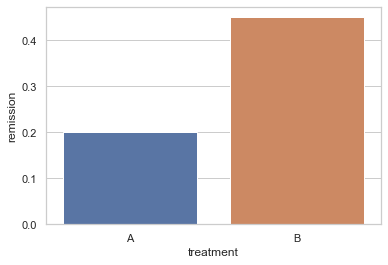

In [9]:
# graphical representation in form of bar graph
_ = sns.barplot(x = 'treatment', y = 'remission', data = df_long, ci = None)

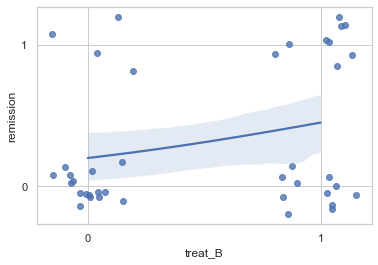

In [10]:
# scatter plot with logistic regression fit
ax = sns.regplot(x = 'treat_B', y = 'remission', \
            data = df_long.assign(treat_B = 1 * (df_long.treatment == 'B')), \
           x_jitter = 0.2, y_jitter = 0.2, logistic = True)

ax.set_xticks([0, 1])
_ = ax.set_yticks([0, 1])

From the above exploratory analysis, it can be seen that in the given sample, **treatment B** has remission rate (probability of remission) of **0.45** (45%) and **treatment A** has remission rate of **0.2** (20%). It is an **approximation** to the **real probability of remission** of 0.5 (treatment B) and 0.3 (treatment A) of the underlying probability distribution (bernoulli), which are unfortunately **hidden from us.**

We will do formal analyses checking various questions.

## Checking sample proportion of remission against a hypothesised probability of remission

For the present problem, we will use the **sample for treatment A** (generated from bernoulli probability distribution with probability of remission of 0.3).

In [11]:
# Remission status of sample from treatment A
df_wide.rem_A.values

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [12]:
# Hypothesis testing framework, testing against null hypothesis of probability of remission of 0.5
p_val_prop = stsa.binom_test(df_wide.rem_A.values.sum(), \
                                        len(df_wide.rem_A.values), \
                                        prop = 0.5)
print(f'p value of probability of remission against null hypothesis of probability of 0.5: '
      f'{p_val_prop:.3f}')

p value of probability of remission against null hypothesis of probability of 0.5: 0.012


As we get **p value < 0.05**, we **reject** the null hypothesis that the probability of remission is 0.5

In [13]:
# 95% confidence interval of the probability of remission for treatment A
confint_prop = stsa.proportion_confint(df_wide.rem_A.values.sum(), \
                           len(df_wide.rem_A.values))
print(f'95% Confidence Interval of probability of remission: '
      f'{confint_prop[0]:.3f} - {confint_prop[1]:.3f}')

95% Confidence Interval of probability of remission: 0.025 - 0.375


**95% confidence interval**, which is the interval that **include all the hypothesised probabilities** of remission which we **are not able to reject** (p > 0.05), is 0.025 to 0.375. So, we say that the probability of remission for treatment A is any value between 0.025 (2.5%) to 0.375 (37.5%). It is to be noted that, real probability is 0.3, which is included in the above interval.

## Checking sample difference in proportion of remission against a hypothesised difference in probability of remission

For the present example, we will **compare the probability** of achieving remission after **treatment B** with the same after **treatment A**. For comparing, we will use **difference in probability of remission** ($p_{rem}^B - p_{rem}^A$).

We will test the sample difference against **null hypothesis of 0 difference**.

In [14]:
two_samp_prop = stprop.test_proportions_2indep(\
                                        count1 = df_wide.rem_B.sum(), \
                                        nobs1 = len(df_wide.rem_B), \
                                        count2 = df_wide.rem_A.sum(), \
                                        nobs2 = len(df_wide.rem_A), \
                                        value = 0, compare = 'diff')

In [15]:
two_samp_prop_ci = stprop.confint_proportions_2indep(count1 = df_wide.rem_B.sum(), \
                                        nobs1 = len(df_wide.rem_B), \
                                        count2 = df_wide.rem_A.sum(), \
                                        nobs2 = len(df_wide.rem_A), \
                                        compare = 'diff')

In [16]:
print(f'''difference in proportion: {two_samp_prop.diff}
95% confidence interval: {two_samp_prop_ci[0]:.3f} - {two_samp_prop_ci[1]:.3f}
p value against null hypothesis of no difference: {two_samp_prop.pvalue:.3f}''')

difference in proportion: 0.25
95% confidence interval: -0.039 - 0.490
p value against null hypothesis of no difference: 0.101


Despite having the difference in probability of 0.2 (**hidden from us**), the **present test is not able to detect the difference**, as is depicted by the p > 0.05 and as the 95% confidence interval includes 0 difference. 

## Checking for independence of treatment and remission status

There are a few other tests (as part of **contingency table analysis**) to detect **independence between treatment and remission status**.

In [17]:
table22 = pd.crosstab(df_long.remission, df_long.treatment).values

In [18]:
table22

array([[16, 11],
       [ 4,  9]])

In [19]:
table22_stats = stsa.Table2x2(table22)

### Chi square test

In [20]:
print(table22_stats.test_nominal_association())

df          1
pvalue      0.0914306291819661
statistic   2.8490028490028494


### Odds Ratio

In [21]:
table22_stats.oddsratio

3.272727272727273

In [22]:
# 95% confidence interval of OR, no difference is OR = 1
table22_stats.oddsratio_confint(0.05)

(0.8023103736132532, 13.349875751221328)

### Risk Ratio

In [23]:
table22_stats.riskratio

1.9259259259259258

In [24]:
# 95% confidence interval of RR, no difference is RR = 1
table22_stats.riskratio_confint(0.05)

(0.8041975991252316, 4.612287671821351)

<a id="samp-size-bin"></a>
## Sample Size Calculation

From the above example, we saw that despite the real difference in probability of achieving remission of 0.2 between treatment B and A, **our test could not detect the difference**.

We can see from the graph below, that with sample size of 20 (as we had), the power of the test is only around 0.2. It means that **with the sample size of 20**, our test will be **able to detect a difference of 0.2 (20%) only 20% of times**.

In [25]:
power_propdiff = partial(stprop.power_proportions_2indep, diff = 0.2, prop2 = 0.3)

nsamps = np.arange(1, 201)

powers = np.array([power_propdiff(nobs1 = nsamp).power for nsamp in nsamps])

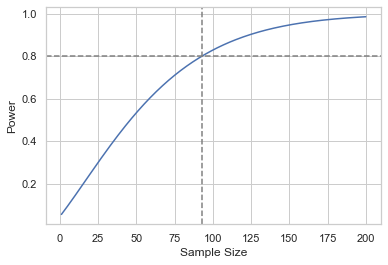

In [26]:
plt.plot(nsamps, powers)
plt.axhline(0.8, linestyle = 'dashed', color = 'gray', linewidth = 1.5)
plt.axvline(nsamps[powers >= 0.8].min(), linestyle = 'dashed', color = 'gray', linewidth = 1.5)
plt.xlabel('Sample Size')
_ = plt.ylabel('Power')

In [27]:
nsamps[powers >= 0.8].min()

93

The above calculation shows that a **sample size of 93 (each arm)** is required to detect a difference of 0.2 80% of times (power of study of 0.8).

## Logistic Regression Model

In [28]:
logit_model = smf.logit('remission ~ treatment', data = df_long)

In [29]:
logit_model_fit = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.594271
         Iterations 5


In [30]:
logit_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              remission   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Nov 2021   Pseudo R-squ.:                 0.05758
Time:                        20:15:59   Log-Likelihood:                -23.771
converged:                       True   LL-Null:                       -25.223
Covariance Type:            nonrobust   LLR p-value:                   0.08831
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.3863      0.559     -2.480      0.013      -2.482      -0.291
treatment[T.B]     1.1856      0.717      1.653      0.098      -0.220       2.592
==================================================================================
"""

In [31]:
np.exp(logit_model_fit.params[1])

3.2727272727272734

In [32]:
np.exp(logit_model_fit.conf_int().iloc[1, :])

0     0.802310
1    13.349876
Name: treatment[T.B], dtype: float64